In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '.../data'

Mounted at /content/drive


In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics
import numpy as np
import random
from collections import defaultdict

In [ ]:
#See documentation from race_confoundment_sex.ipynb and race_confoundment_age.ipynb
def create_age_biased_test_set(df, non_df, bias):
  #Age is binarized by 41
  prop1 = sum(df['Age']<41)/len(df)
  prop2 = sum(non_df['Age']<41)/len(non_df)
  if bias<= prop1:
    biased_df = pd.concat([df, df[df['Age']<41].sample(int((sum(df['Age']<41)-len(df)*bias)/(1-bias)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_df = pd.concat([df, df[df['Age']>=41].sample(int((sum(df['Age']>=41)-len(df)*(1-bias))/bias), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  bias2 = 1-bias
  if bias2<= prop2:
    biased_non_df = pd.concat([non_df, non_df[non_df['Age']<41].sample(int((sum(non_df['Age']<41)-len(non_df)*bias2)/(1-bias2)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_non_df = pd.concat([non_df, non_df[non_df['Age']>=41].sample(int((sum(non_df['Age']>=41)-len(non_df)*(1-bias2))/bias2), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  return(pd.concat([biased_df,biased_non_df]))

def create_sex_biased_test_set(df, non_df, bias):
  prop1 = sum(df['Gender']=='F')/len(df)
  prop2 = sum(non_df['Gender']=='F')/len(non_df)
  if bias<= prop1:
    biased_df = pd.concat([df, df[df['Gender']=='F'].sample(int((sum(df['Gender']=='F')-len(df)*bias)/(1-bias)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_df = pd.concat([df, df[df['Gender']=='M'].sample(int((sum(df['Gender']=='M')-len(df)*(1-bias))/bias), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  bias2 = 1-bias
  if bias2<= prop2:
    biased_non_df = pd.concat([non_df, non_df[non_df['Gender']=='F'].sample(int((sum(non_df['Gender']=='F')-len(non_df)*bias2)/(1-bias2)), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  else:
    biased_non_df = pd.concat([non_df, non_df[non_df['Gender']=='M'].sample(int((sum(non_df['Gender']=='M')-len(non_df)*(1-bias2))/bias2), random_state = 2022)]).drop_duplicates(subset=['Path'], keep=False)
  return(pd.concat([biased_df,biased_non_df]))

def binarize_by_race(df, race):
    race_df = df[df['Race/Ethnicity'].str.contains(race)]
    non_race_df = df[~df['Race/Ethnicity'].str.contains(race)]
    return race_df, non_race_df

*CheXpert* Trained;
MIMIC Tested

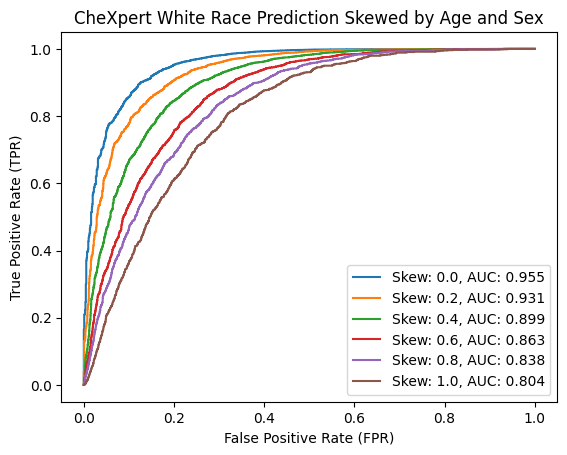

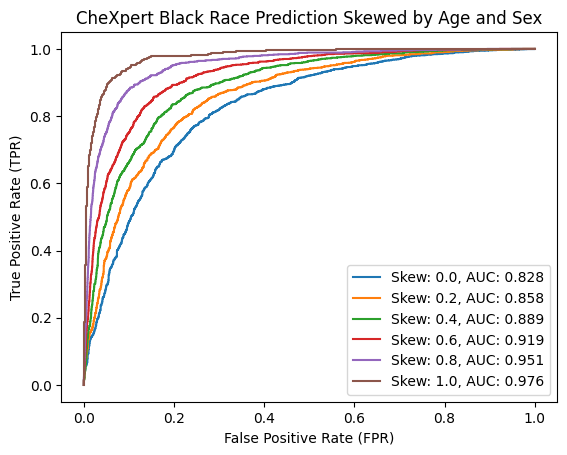

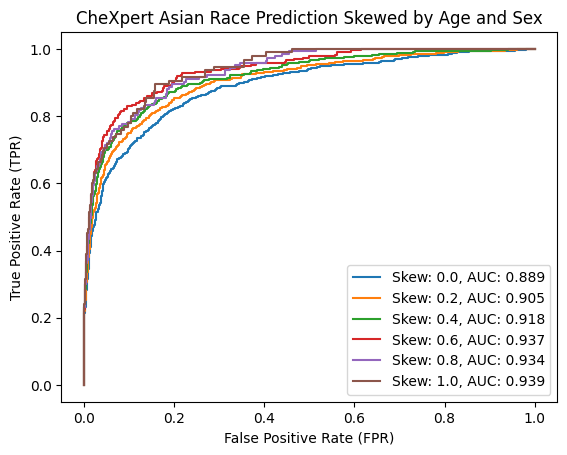

In [ ]:
races = ['White', 'Black', 'Asian']
prob_dict = {'White': 2, 'Asian': 0, 'Black': 1}
for race in races:
  df = pd.read_csv(path + '/chexpert_race1_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Age'].isna()]
  df = df[~df['Gender'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  #For each bias/skew, created the appropriate skewed dataset with respect to age and sex and calculate AUCROC
  for bias in np.arange(0, 1.1, 0.2):
      race_df, nonrace_df = binarize_by_race(df, race)
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      race_df, nonrace_df = binarize_by_race(biased_test_df, race)
      biased_test_df = create_sex_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert ' + race +' Race Prediction Skewed by Age and Sex')
  # Show the plot
  plt.show()

CheXpert Trained; CheXpert Tested

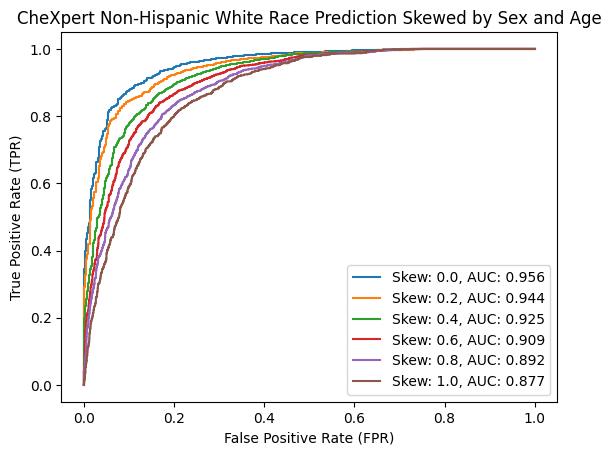

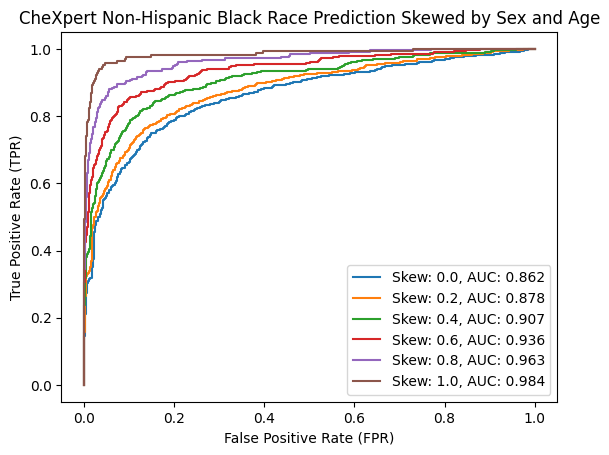

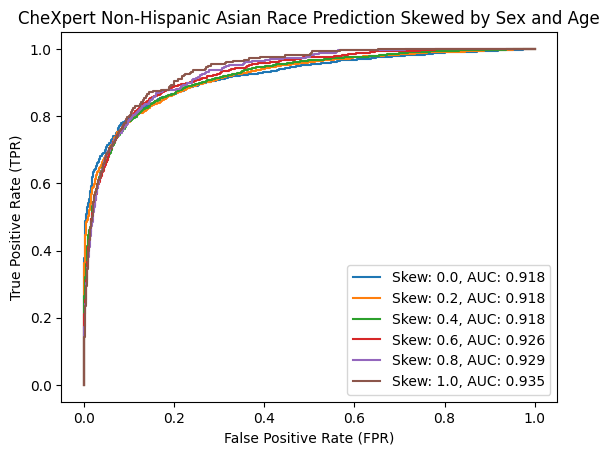

In [ ]:
races = ['Non-Hispanic White', 'Non-Hispanic Black', 'Non-Hispanic Asian']
prob_dict = {'Non-Hispanic White': 2, 'Non-Hispanic Asian': 0, 'Non-Hispanic Black': 1}
for race in races:
  df = pd.read_csv(path + '/chexpert_race1_chexpert_test.csv')
  df = df[~df['Age'].isna()]
  df = df[~df['Gender'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  for bias in np.arange(0, 1.1, 0.2):
      race_df, nonrace_df = binarize_by_race(df, race)
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      race_df, nonrace_df = binarize_by_race(biased_test_df, race)
      biased_test_df = create_sex_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('CheXpert ' + race +' Race Prediction Skewed by Sex and Age')
  # Show the plot
  plt.show()

MIMIC Trained; MIMIC Tested

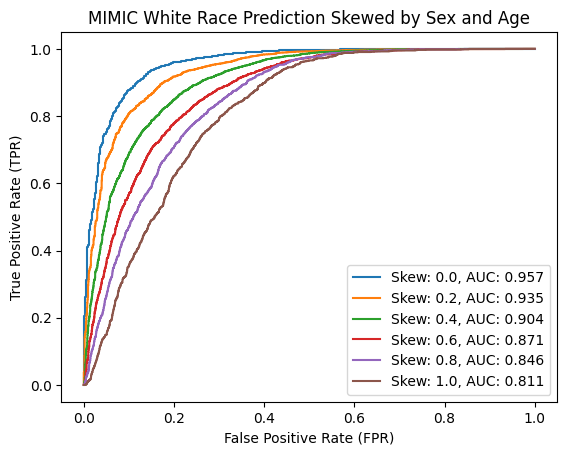

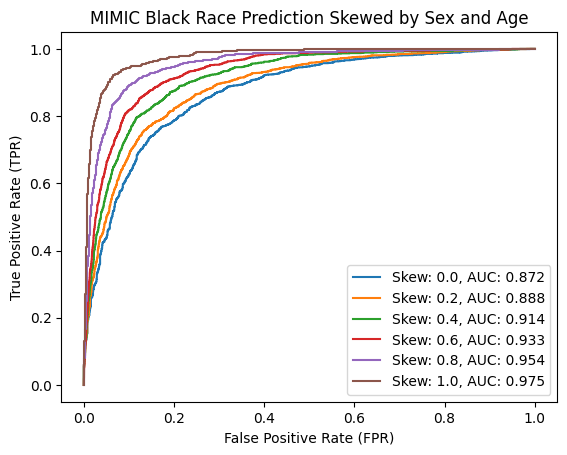

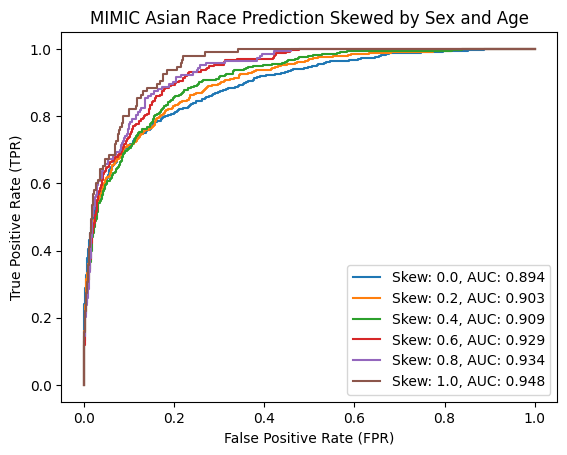

In [ ]:
races = ['White', 'Black', 'Asian']
prob_dict = {'White': 4, 'Asian': 0, 'Black': 1}
for race in races:
  df = pd.read_csv(path + '/mimic_race_mimic_test.csv')
  df = df.rename(columns={'age': 'Age'})
  df = df[~df['Age'].isna()]
  df = df[~df['Gender'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)
  for bias in np.arange(0, 1.1, 0.2):
      race_df, nonrace_df = binarize_by_race(df, race)
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      race_df, nonrace_df = binarize_by_race(biased_test_df, race)
      biased_test_df = create_sex_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC ' + race +' Race Prediction Skewed by Sex and Age')
  # Show the plot
  plt.show()

MIMIC Trained; CheXpert Tested

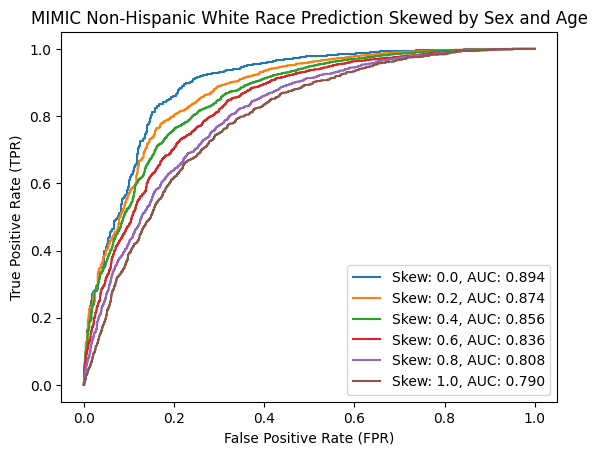

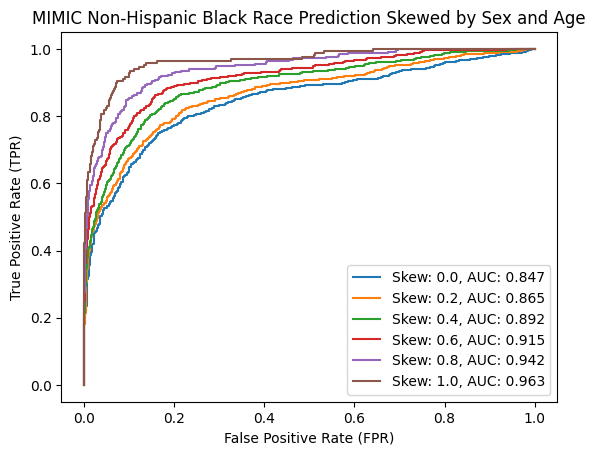

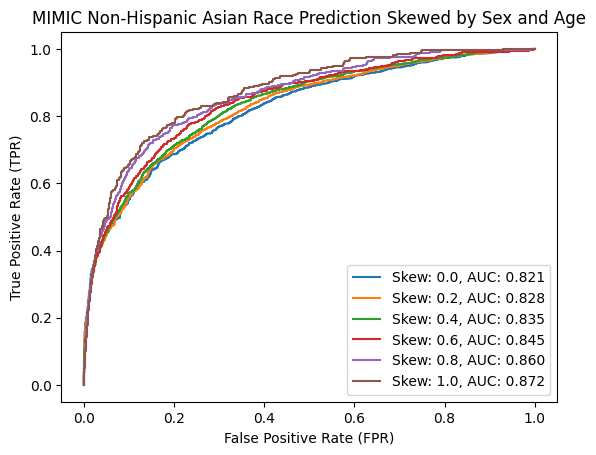

In [ ]:
races = ['Non-Hispanic White', 'Non-Hispanic Black', 'Non-Hispanic Asian']
prob_dict = {'Non-Hispanic White': 4, 'Non-Hispanic Asian': 0, 'Non-Hispanic Black': 1}
for race in races:
  df = pd.read_csv(path + '/mimic_race_chexpert_race_v1_test.csv')
  df = df[~df['Age'].isna()]
  df = df[~df['Gender'].isna()]
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.rstrip(']')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].str.lstrip('[')
  df['Race/Ethnicity_Probability'] = df['Race/Ethnicity_Probability'].apply(np.fromstring, sep=',', dtype = float)

  for bias in np.arange(0, 1.1, 0.2):
      race_df, nonrace_df = binarize_by_race(df, race)
      biased_test_df = create_age_biased_test_set(race_df, nonrace_df, bias)
      race_df, nonrace_df = binarize_by_race(biased_test_df, race)
      biased_test_df = create_sex_biased_test_set(race_df, nonrace_df, bias)
      fpr, tpr, _ = metrics.roc_curve(y_true = biased_test_df['Race/Ethnicity'],y_score = [prob[prob_dict[race]] for prob in biased_test_df['Race/Ethnicity_Probability']], pos_label = race)
      auc = metrics.auc(fpr, tpr)
      plt.plot(fpr, tpr, label=f'Skew: {bias:.1f}, AUC: {auc:.3f}')
  # Add labels, title, and legend
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.legend(loc='lower right')
  plt.title('MIMIC ' + race +' Race Prediction Skewed by Sex and Age')
  # Show the plot
  plt.show()